# Анализ поездок сервиса аренды самокатов GoFast

### Описание проекта

Проанализировать данные о некоторых пользователях из нескольких городов, а также об их поездках и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.<br>
<br>
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
без подписки:<br>
абонентская плата отсутствует;<br>
стоимость одной минуты поездки — 8 рублей;<br>
стоимость старта (начала поездки) — 50 рублей;<br>
<br>
с подпиской Ultra:<br>
абонентская плата — 199 рублей в месяц;<br>
стоимость одной минуты поездки — 6 рублей;<br>
стоимость старта — бесплатно.<br>
<br>
Необходимо помочь бизнесу вырасти, проверив гипотезы:<br>
1. Тратят ли пользователи с подпиской больше времени на поездки?
2. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
3. Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

### План работы

1. Загрузка данных
2. Предобработка данных
    1. Корректировка типов данных
    2. Проверка на явные/неявные дубликаты
    3. Проверка пропусков
    4. Создание новых столбцов
    5. Проверка на аномалии
3. Исследовательский анализ данных. Описать и визуализировать:
    1. Частоту встречаемости городов
    2. Соотношение пользователей с подпиской и без подписки
    3. Возраст пользователей
    4. Расстояние, которое пользователь преодолел за одну поездку
    5. Продолжительность поездок
4. Объединение данных
    1. Объединить все датафреймы в один
    2. Разделить общий датафрейм на пользователей с подпиской и без
    3. Визуализировать информацию о расстоянии и времени поездок для пользователей обеих категорий
5. Подсчёт выручки
    1. Найти суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц
    2. Посчитать помесячную выручку для каждого пользователя
6. Проверка гипотез
    1. Ответить на вопросы, постваленные бизнесом
7. Общий вывод

### Описание данных

<b>Пользователи</b> - users_go.csv<br>
<br>
`user_id` - уникальный идентификатор пользователя<br>
`name` - имя пользователя<br>
`age` - возраст<br>
`city` - город<br>
`subscription_type` - тип подписки (free, ultra)

<b>Поездки</b> - rides_go.csv<br>
<br>
`user_id` - уникальный идентификатор пользователя<br>
`distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах)<br>
`duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»<br>
`date` - дата совершения поездки

<b>Подписки</b> - subscriptions_go.csv<br>
<br>
`subscription_type` - тип подписки<br>
`minute_price` - стоимость одной минуты поездки по данной подписке<br>
`start_ride_price` - стоимость начала поездки<br>
`subscription_fee` - стоимость ежемесячного платежа

### Шаг 2. Загрузка данных

In [1]:
# Подключим библиотеки
import pandas as pd
import numpy as np
import os
from scipy import stats as st
from matplotlib import pyplot as plt

In [2]:
# Прочитаем данные
pth1, pth1_1 = 'users_go.csv', '/datasets/users_go.csv'
pth2, pth2_1 = 'rides_go.csv', '/datasets/rides_go.csv'
pth3, pth3_1 = 'subscriptions_go.csv', '/datasets/subscriptions_go.csv'

if os.path.exists(pth1):
    users_data = pd.read_csv(pth1)
    rides_data = pd.read_csv(pth2)
    subs_data = pd.read_csv(pth3)
elif os.path.exists(pth2_1):
    users_data = pd.read_csv(pth1_1)
    rides_data = pd.read_csv(pth2_1)
    subs_data = pd.read_csv(pth3_1)
else:
    print('Something is wrong')

pd.set_option('display.max_columns', None)

#### Посмотрим на общую информацию по каждому датафрейму и на первые строки каждого датафрейма

##### users_data

In [3]:
users_data.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Всего 1565 строк и 5 столцов.<br>
Нет пропусков, это хорошо. Также столбцы имеют корректные типы данных

##### rides_data

In [5]:
rides_data.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
rides_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Всего 18068 строк и 4 столбца<br>
Нет пропусков, это хорошо. Столбец `date` стоит привести к типу datetime, займемся этим на шаге предобработки данных

##### subs_data

In [7]:
subs_data.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Можно сказать, что это датафрейм-описание. Всего 2 строки и 4 столбца, которые содержат информацию о каждом типе подписки "free" и "ultra"<br>
Пропусков, некорректных типов данных также нет

#### Вывод

В датафреймах нет пропусков и всего в одном столбце `date` датафрейма rides_data имеется некорректный тип данных. Займемся этим на следующем этапе

### Шаг 3. Предобработка данных

#### Корректировка типа данных в столцах

На предыдущем этапе мы выяснили, что некорректный тип данных только в одном столбце: `date` датафрейма rides_data. Поэтому приведем его к корректному типу - "datetime". Мы делаем это потому, что в pandas предусмотрены удобные методы для работы типом "datetime"

In [9]:
# Приведем столбец к корректному типу
rides_data['date'] = pd.to_datetime(rides_data['date'], format='%Y-%m-%d')

In [10]:
# Посмотрим теперь на тип данных столбца
rides_data.dtypes

user_id              int64
distance           float64
duration           float64
date        datetime64[ns]
dtype: object

In [11]:
# Еще раз взглянем на наш датафрейм
rides_data.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


Отображение столбца `date` не изменилось, зато изменился его тип данных, чтобы в дальнейшем было удобнее с ним работать

#### Создание нового столбца с номером месяца для датафрейма rides_data

In [12]:
# Создадим новый столбец с месяцем
rides_data['month'] = pd.DatetimeIndex(rides_data['date']).month

In [13]:
# Посмотрим на обновленный датафрейм
rides_data.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Новый столбец добавлен корректно

#### Проверка дубликатов

##### users_data

В датафрейме users_data явные дубликаты могут мешать только в столбце `user_id`.<br>
А в остальных столбцах дубликаты вполне ожидаемы

In [14]:
users_data['user_id'].duplicated().sum()

31

Удалим дубликаты в этом столбце, так как нам не нужна информация об одних и тех же пользователях

In [15]:
users_data = users_data.drop_duplicates(subset=['user_id'])
users_data = users_data.reset_index(drop=True)

По логике, после удаления дубликатов, количество уникальных значений в стролбце `user_id` должно совпадать с длиной всего датафрейма. Убедимся в этом

In [16]:
if len(users_data['user_id'].unique()) == len(users_data):
    print('Длина совпадает')
else:
    print('Длина не совпадает')

Длина совпадает


В теории в столбцах `city` и `subscription_type` могут хранится неявные дубликаты. Проверим

In [17]:
users_data['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

In [18]:
users_data['subscription_type'].unique()

array(['ultra', 'free'], dtype=object)

Неявных дубликатов нет

Обработка дубликатов в датафрейме users_data выполнена успешно

##### rides_data

Посмотрим на количество дубликатов во всем датафрейме

In [19]:
rides_data.duplicated().sum()

0

Дубликатов нет, обрабатывать нечего

##### Промежуточный вывод

Из всех трех датафреймов дубликаты оказались только в датафрейме "users_data" в столбце `user_id`.<br>
В остальных датафреймах дубликатов не обнаружено.<br>
Искать дубликаты в датафрейме "subs_data" нет смысла, так как он состоит всего из 2 строк и отсутствие дубликатов видно невооруженным глазом

#### Проверка аномальных значений

##### users_data

Посмотрим на гистограммы числовых столбцов датафрейма

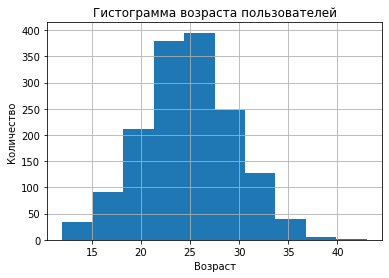

In [20]:
plt.title('Гистограмма возраста пользователей')
plt.ylabel('Количество')
plt.xlabel('Возраст')
plt.grid(True)
plt.hist(users_data['age'])
plt.show()

На оси x график заканчивается до 45, значит выбивающихся значений нет

##### rides_data

Посмотрим на гистограммы столбоцов `distance` и `duration`

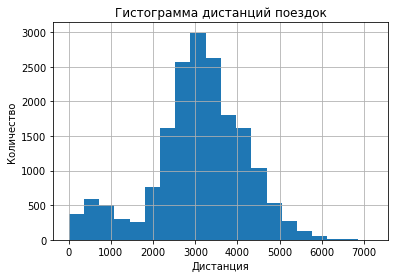

Минимальное пройденное расстояние 0.855682925681208
Максимальное пройденное расстояние 7211.007744598519


In [21]:
plt.title('Гистограмма дистанций поездок')
plt.ylabel('Количество')
plt.xlabel('Дистанция')
plt.grid(True)
plt.hist(rides_data['distance'], bins=20)
plt.show()

print('Минимальное пройденное расстояние', rides_data['distance'].min())
print('Максимальное пройденное расстояние', rides_data['distance'].max())

Данные в столбце `distance` в пределах нормы

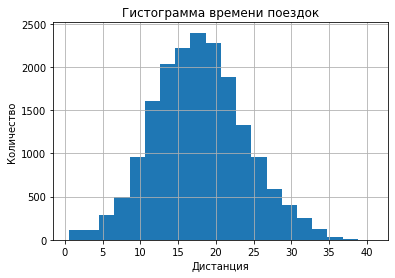

Минимальное время сессии 0.5
Максимальное время сессии 40.82396261922424


In [22]:
plt.title('Гистограмма времени поездок')
plt.ylabel('Количество')
plt.xlabel('Дистанция')
plt.grid(True)
plt.hist(rides_data['duration'], bins=20)
plt.show()

print('Минимальное время сессии', rides_data['duration'].min())
print('Максимальное время сессии', rides_data['duration'].max())

Гистограмма столбца `duration` выглядит ожидаемо

##### Промежуточный вывод

При проверке датафреймов аномальных значений не найдено

#### Вывод

1. В столбце `date` датафрейма "rides_data" изменили тип данных с object на datetime. Так как в столбце хранится информации о дате и в pandas есть удобные методы для работы с типом данных datetime
2. В датафрейме "rides_data" добавили новый столбец `month`, который хранит информацию о месяце поездки
3. Обработали дубликаты.
    1. Дубликаты найдены только в датафрейме "users_data" столбце `user_id`.
    2. В остальных датафреймах дубликатов не найдено
4. Аномальные значения в датафреймах не найдены
5. Пропусков в датафреймах также нет

### Шаг 4. Исследовательский анализ данных

#### Частота встречаемости городов

Посмотрим на сводной таблице, как часто встречаются города в датафрейме

In [23]:
cities_pivot = users_data.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id')
cities_pivot

,user_id
city,
Москва,168
Тюмень,180
Омск,183
Сочи,189
Краснодар,193
Ростов-на-Дону,198
Екатеринбург,204
Пятигорск,219


Построим столбчатую диаграмму для этой таблицы

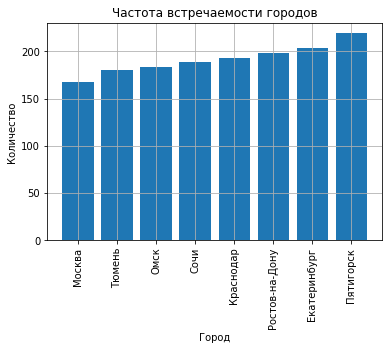

In [24]:
plt.title('Частота встречаемости городов')
plt.ylabel('Количество')
plt.xlabel('Город')
plt.grid(True)
plt.xticks(rotation=90)
plt.bar(cities_pivot.index, cities_pivot['user_id'])
plt.show()

Меньше всего пользователей в Москве, а больше всего в Пятигорсе. Довольно таки интересное наблюдение. Все таки в Москве население почти в 100 раз больше, чем в Пятигорске. (13 миллионнов против 144 тысяч)<br>
Возможно компании стоит проверсти какуб-либо рекламную компанию в крупных городах

#### Cоотношение пользователей с подпиской и без подписки

Проверим какую часть от всего числа пользователей составляют пользователи с подпиской и без

In [25]:
# Посчитаем сколько всего пользователей
len_users = len(users_data)

#Напишем функцию для подсчета частей
def subs_part(sub_type):
    len_users = len(users_data)
    return round(len(users_data[users_data['subscription_type'] == sub_type]) / len_users, 3)

print('Всего пользователей:', len(users_data))
print('Часть пользовтелей с подпиской:', subs_part('ultra'))
print('Часть пользовтелей без подписки:', subs_part('free'))

Всего пользователей: 1534
Часть пользовтелей с подпиской: 0.456
Часть пользовтелей без подписки: 0.544


In [26]:
# Построим сводную таблицу
subs_pivot = users_data.pivot_table(index='subscription_type', values='user_id', aggfunc='count')
subs_pivot['part'] = subs_pivot.index.to_series().apply(subs_part)
subs_pivot

,user_id,part
subscription_type,,
free,835,0.544
ultra,699,0.456


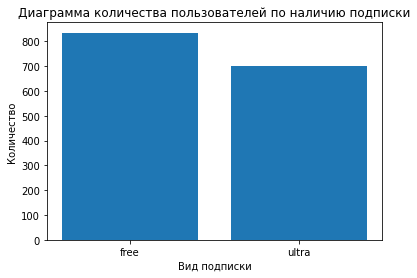

In [27]:
plt.title('Диаграмма количества пользователей по наличию подписки')
plt.xlabel('Вид подписки')
plt.ylabel('Количество')
plt.bar(subs_pivot.index, subs_pivot['user_id'])
plt.show()

Пользователей без подписки почти на 10% больше

#### Возраст пользователей

Посмотрим, как распределен возраст пользователей

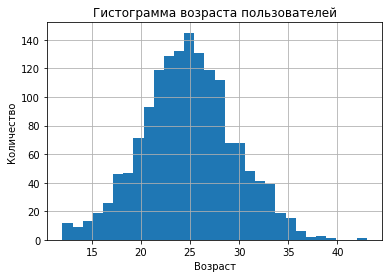

In [28]:
plt.title('Гистограмма возраста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.grid(True)
plt.hist(users_data['age'], bins=30)
plt.show()

Распределение возраста пользователей похоже на нормальное. Больше всего пользователей в возрасте около 25 лет. Чем дальше возраст от наиболее встречающегося значения, тем реже он встречается

#### Расстояние, которое пользователь преодолел за одну поездку

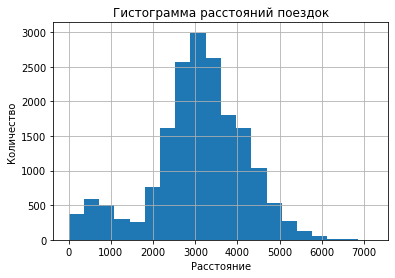

In [29]:
plt.title('Гистограмма расстояний поездок')
plt.xlabel('Расстояние')
plt.ylabel('Количество')
plt.grid(True)
plt.hist(rides_data['distance'], bins=20)
plt.show()

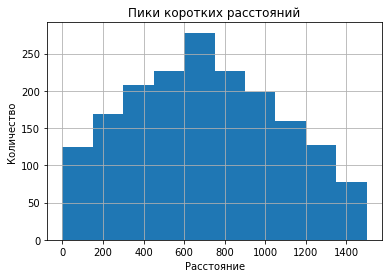

In [30]:
plt.title('Пики коротких расстояний')
plt.xlabel('Расстояние')
plt.ylabel('Количество')
plt.grid(True)
plt.hist(rides_data['distance'], range=(0, 1500))
plt.show()

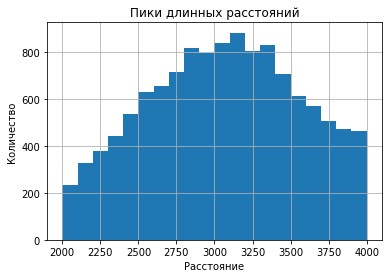

In [31]:
plt.title('Пики длинных расстояний')
plt.xlabel('Расстояние')
plt.ylabel('Количество')
plt.grid(True)
plt.hist(rides_data['distance'], bins=20, range=(2000, 4000))
plt.show()

Больше всего пользователи проезжают около 3км. Больше 5км пользователи проезжают очень редко. Также до 1км пользователи ездят чаще, чем от 1км до 1.8км<br>
На коротких расстояних (до 1км) больше всего поездок по 600-700 метров<br>
На длинных от 2.5 до 3.3 км

#### Продолжительность поездок

Посмотрим на продолжительность поездок

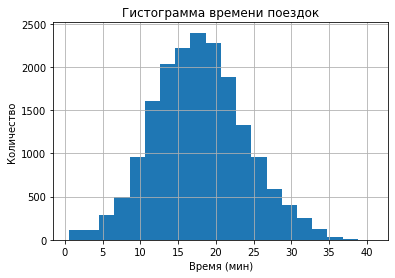

In [32]:
plt.title('Гистограмма времени поездок')
plt.xlabel('Время (мин)')
plt.ylabel('Количество')
plt.grid(True)
plt.hist(rides_data['duration'], bins=20)
plt.show()

Чаще всего пользователи ездят по 17 минут.<br>
Было бы интересно посмотреть, зависит ли время поездки от ее дальности. Посмотрим на корреляцию этих двух параметров

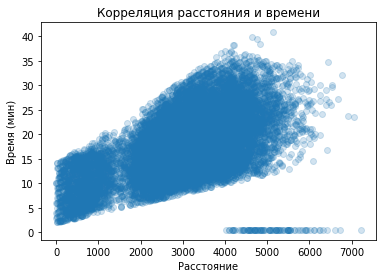

0.5367776552505346


In [33]:
plt.title('Корреляция расстояния и времени')
plt.xlabel('Расстояние')
plt.ylabel('Время (мин)')
plt.scatter(rides_data['distance'], rides_data['duration'], alpha=0.2)
plt.show()
print(rides_data['distance'].corr(rides_data['duration']))

На графике видим необычную ситуацию. Есть пользователи, которые менее, чем за 2 минуты проезжали более 4 км. 

In [34]:
# Посмотрим на эти значения
pivot_dist_dur = rides_data[(rides_data['distance'] >= 3000) & (rides_data['duration'] <= 5)]
pivot_dist_dur

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


In [35]:
pivot_dist_dur['duration'].unique()

array([0.5])

Да, что то странное. Похоже на ошибку в данных. Время для подобных расстояний в пол минуты невозможно.<br>
Будем считать, что это минуты. Вероятнее всего для подобных расстояний, что 0.5 это половина часа, то есть 30 минут

In [36]:
rides_data['duration'] = rides_data['duration'].where(rides_data['duration'] != 0.5, rides_data['duration'] * 60)

In [37]:
rides_data

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11
18064,1534,2840.423057,21.409799,2021-11-16,11
18065,1534,3826.185507,18.435051,2021-11-18,11
18066,1534,2902.308661,16.674362,2021-11-27,11


Строки успешно обработаны. Еще раз взгялнем на график корреляции

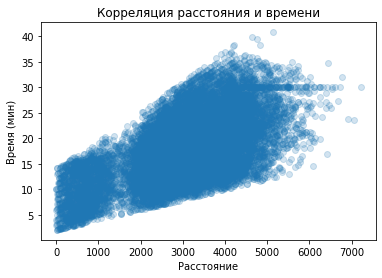

0.5898805754405957


In [38]:
plt.title('Корреляция расстояния и времени')
plt.xlabel('Расстояние')
plt.ylabel('Время (мин)')
plt.scatter(rides_data['distance'], rides_data['duration'], alpha=0.2)
plt.show()
print(rides_data['distance'].corr(rides_data['duration']))

Аномальных значений теперь не видно на графике. Коэффициент Пирсона немного вырос и стал равен 0.58. Нельзя сказать, что они линейно зависят друг от друга. Хотя небольшая зависимость и есть. Возможно это обусловлено еще и тем, что разные пользователи используют самокаты по-разному.

#### Вывод

1. Меньше всего пользователей в Москве, а больше всего в Пятигорсе. Довольно таки интересное наблюдение. Все таки в Москве население почти в 100 раз больше, чем в Пятигорске. (13 миллионнов против 144 тысяч).
2. Пользователей без подписки почти на 10% больше. 835 против 699
3. Больше всего пользователей в возрасте около 25 лет. Чем дальше возраст от наиболее встречающегося значения, тем реже он встречается
4. Больше всего пользователи проезжают около 3км. Больше 5км пользователи проезжают очень редко. Также до 1км пользователи ездят чаще, чем от 1км до 1.8км
5. Чаще всего пользователи ездят по 17 минут.
6. Преобразованы строки, где пользователи за 30с проезжали от 4 до 7 км. 30с заменили на 30м.
7. Зависимость между параметрами `distance` и `duration` по коэффициенту Пирсона равена 0.58. Нельзя сказать, что они линейно зависят друг от друга. Хотя небольшая зависимость и есть. Возможно это обусловлено еще и тем, что разные пользователи используют самокаты по-разному.

### Шаг 5. Объединение данных

#### Объединение данных о пользователях, поездках и подписках в один датафрейм

Объединим датафреймы users_data, rides_data, subs_data в один

In [39]:
# Сначала к таблице rides_data присоединим users_data
all_data = rides_data.merge(users_data, on='user_id', how='left')

# Теперь к получившейся таблицы all_data присоединим subs_data
all_data = all_data.merge(subs_data, on='subscription_type', how='left')

all_data.tail(10)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
18058,1534,195.447469,6.469074,2021-06-11,6,Альберт,25,Краснодар,free,8,50,0
18059,1534,3214.021065,18.343604,2021-06-18,6,Альберт,25,Краснодар,free,8,50,0
18060,1534,3644.708038,20.289416,2021-08-08,8,Альберт,25,Краснодар,free,8,50,0
18061,1534,3977.744996,26.916544,2021-08-20,8,Альберт,25,Краснодар,free,8,50,0
18062,1534,4928.173852,22.560373,2021-09-13,9,Альберт,25,Краснодар,free,8,50,0
18063,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
18064,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
18065,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
18066,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0
18067,1534,2371.711192,15.893917,2021-12-29,12,Альберт,25,Краснодар,free,8,50,0


Проверим размерность и наличие пропусков

In [40]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Размер датафрейма теперь состоавляет 18068 строк. Как и предполагалось, потому что при соединении у самого большого датафрема было именно 18068 строк.<br>
В новом датафрейме пропусков также нет

#### Создание доплнительных датафреймов

##### c данными о пользователях без подписки

In [41]:
# Датасет с пользователями без подписки
subs_free_data = all_data[all_data['subscription_type'] == 'free']
subs_free_data.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


#### Датасет с пользователями с подпиской

In [42]:
# Датасет с пользователями c подпиской
subs_ultra_data = all_data[all_data['subscription_type'] == 'ultra']
subs_ultra_data.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


#### Визуализация информации о расстоянии и времени поездок для пользователей обеих категорий.

##### без подписки

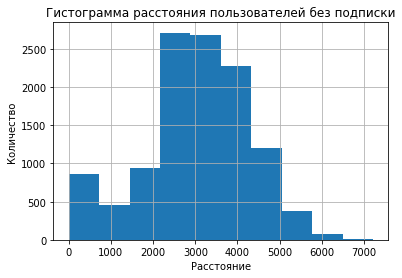

In [43]:
# Расстояние
plt.title('Гистограмма расстояния пользователей без подписки')
plt.xlabel('Расстояние')
plt.ylabel('Количество')
plt.grid(True)
plt.hist(subs_free_data['distance'])
plt.show()

График похож на общую гистограмму по всем поездкам. Больше всего пользователи без подписки ездять от 2 до 3.5 км. На расстояния более 6км почти не ездят. Еще пользователи без подписки любят поездки на короткие расстояния (до 1км)

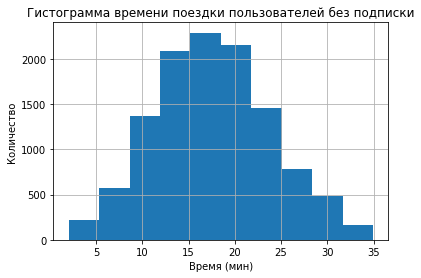

In [44]:
# Время
plt.title('Гистограмма времени поездки пользователей без подписки')
plt.xlabel('Время (мин)')
plt.ylabel('Количество')
plt.grid(True)
plt.hist(subs_free_data['duration'])
plt.show()

Распределение времени поездки пользователей без подписки ничем не отличается от времени всех пользователей. Наиболее частые поездки около 17 минут

##### с подпиской

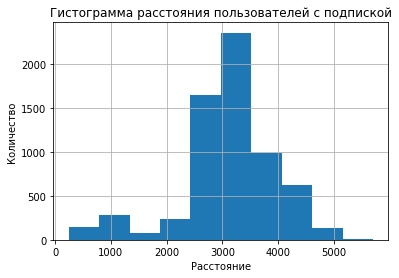

In [45]:
# Расстояние
plt.title('Гистограмма расстояния пользователей с подпиской')
plt.xlabel('Расстояние')
plt.ylabel('Количество')
plt.grid(True)
plt.hist(subs_ultra_data['distance'])
plt.show()

Здесь график уже отличается от общего. Основная масса значение также лежит примерно от 2.5 до 3.5 км. Но главное отличие в том, что на короткие расстояния пользователи с подпиской почти не ездят. Отличие почти в 2 раза по сравнению с пользователями без подписки.<br>
Можно сделать вывод, что основная выгода подписки раскрывается на более длинных растояниях, чем на коротких

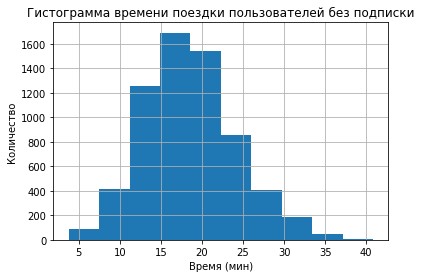

In [46]:
# Время
plt.title('Гистограмма времени поездки пользователей без подписки')
plt.xlabel('Время (мин)')
plt.ylabel('Количество')
plt.grid(True)
plt.hist(subs_ultra_data['duration'])
plt.show()

Распределение времени поездки похоже на нормальное. Что логично. Чаще всего пользователи ездят по 17 минут. График мало чем отдичается от пользователей без подписки

<p>Для наглядности поcтроим гистограммы по пользователям с подпиской и без на одной графике<a name="double_hists"></a></p>

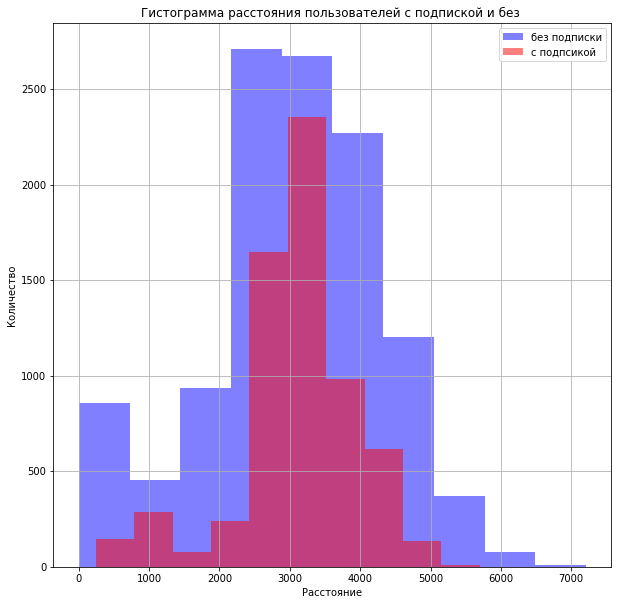

In [62]:
plt.figure(figsize=(10, 10))
plt.title('Гистограмма расстояния пользователей с подпиской и без ')
plt.xlabel('Расстояние')
plt.ylabel('Количество')
plt.grid(True)
plt.hist(subs_free_data['distance'], alpha=0.5, color='blue', label='без подписки')
plt.hist(subs_ultra_data['distance'], alpha=0.5, color='red', label='с подпсикой')
plt.legend(loc='upper right')
plt.show()

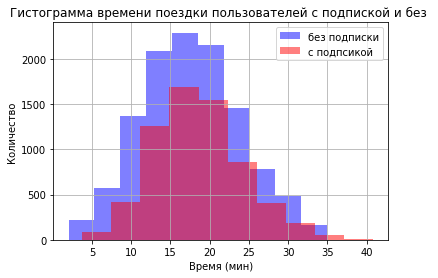

In [48]:
plt.title('Гистограмма времени поездки пользователей с подпиской и без ')
plt.xlabel('Время (мин)')
plt.ylabel('Количество')
plt.grid(True)
plt.hist(subs_free_data['duration'], alpha=0.5, color='blue', label='без подписки')
plt.hist(subs_ultra_data['duration'], alpha=0.5, color='red', label='с подпсикой')
plt.legend(loc='upper right')
plt.show()

#### Вывод

По итогам этого исследования можно сказать, что среднее время поездки 17-18 минут.<br>
А также, что пользователи с подпиской чаще выирают поездки на более длинные расстояния, чем на короткие. Из чего можно сделать вывод, что выгода подписки раскрывается на более длинных дистанциях, а на коротких для пользователей выгоды в подписке мало

### Шаг 6. Подсчёт выручки

#### Суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц

In [49]:
agg_data = all_data.pivot_table(index=['user_id', 'month'], values=['distance', 'duration', 'subscription_type'],
                      aggfunc={'distance': 'sum', 'duration': 'sum', 'subscription_type': 'count'}).reset_index()
agg_data = agg_data.rename(columns={'subscription_type': 'rides'})
agg_data.head(10)

,user_id,month,distance,duration,rides
0,1,1,7027.511294,41.416640,2
1,1,4,754.159807,6.232113,1
2,1,8,6723.470560,44.776802,2
3,1,10,5809.911100,31.578017,2
4,1,11,7003.499363,53.397424,3
5,1,12,6751.629942,27.203912,2
6,2,3,10187.723006,60.959959,3
7,2,4,6164.381824,39.048633,2
8,2,6,3255.338202,13.851127,1
9,2,7,6780.722964,46.170157,2


#### Помесячная выручка, которую принёс каждый пользователь

In [50]:
# Напишем функцию для подсчета помесячной выручки
def month_profit():
    # Создаем копию датафрейма, чтобы не вносить изменений в основной
    # Специально использую датафрейм до группироки, чтобы округлить каждое значение
    all_data_copy = all_data.copy()
    # В копии датафрейма округляем значения
    all_data_copy['duration'] = np.ceil(all_data_copy['duration'])
    # Создаем сводную таблицу для копии датафрейма (с уже округленными значениями)
    group = all_data_copy.pivot_table(
        index=['user_id', 'month', 'subscription_type'],
        values=['duration', 'age', 'minute_price', 'start_ride_price', 'subscription_fee'], 
        aggfunc={'duration': 'sum', 
                 'age': 'count', 
                 'minute_price': 'max', 
                 'start_ride_price': 'max', 
                 'subscription_fee': 'max'})
    # Сбрасываем индексы
    group = group.reset_index()
    # В новом столбце производим расчеты
    group['month_profit'] = (
        group['duration'] * group['minute_price']) + (
        group['age'] * group['start_ride_price']) + group['subscription_fee']
    # Возвращаем два столбца с суммой вырочки и видом подписки
    return group[['month_profit', 'subscription_type']]

# Так как у нас индексы в изначально сгрупированной таблице и возвращенной функции совпадают, 
# просто джоиним их по индексу.
month_profit = month_profit()
agg_data = agg_data.join(month_profit)
agg_data

,user_id,month,distance,duration,rides,month_profit,subscription_type
0,1,1,7027.511294,41.416640,2,451.0,ultra
1,1,4,754.159807,6.232113,1,241.0,ultra
2,1,8,6723.470560,44.776802,2,475.0,ultra
3,1,10,5809.911100,31.578017,2,391.0,ultra
4,1,11,7003.499363,53.397424,3,535.0,ultra
...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,24.812678,2,308.0,free
11327,1534,8,7622.453034,47.205960,2,484.0,free
11328,1534,9,4928.173852,22.560373,1,234.0,free
11329,1534,11,13350.015305,76.342174,4,824.0,free


#### Вывод

Посчитано суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.<br>
А также помесячная выручка, которую принёс каждый пользователь

### Шаг 7. Проверка гипотез

#### Гипотеза 1 <br>
Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Будем считать, что нам нужно сравнить две генеральные совокупности subs_ultra_data и subs_free_data. Использовать выборки не будем, так как обработать совокупности такого размера не будет затруднительно<br>
Сформулируем нулевую и альтернативную гипотезы:<br>
H0 : u1 = u2 - Среднее время поездки пользователей с подпиской и без равны <br>
H1 : u1 > u2 - Среднее время поездки пользователей с подпиской больше, чем у пользователей без подписки <br>


In [51]:
# Сначала просто найдем средние
print('Среднее время пользователей с подпиской:', subs_ultra_data['duration'].mean())
print('Среднее время пользователей без подписки:', subs_free_data['duration'].mean())
print('')

# Задаем уровень статистической значимости
alpha = 0.05

# Проведем ttest для двух генеральных совокупностей
# Мы помним, что пользователей без подписки больше на 10%, поэтому зададим equal_var=False
# Так как альтернативная гипотеза односторонняя, укажем alternative='greater'
result_1 = st.ttest_ind(subs_ultra_data['duration'], 
                        subs_free_data['duration'], 
                        equal_var=False, 
                        alternative='greater')

# Если p-value результата меньше статистической значимости - отвергнем нулевую гипотезу
print('p-value:', result_1.pvalue)

if result_1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
else:
    print('Нулевую гипотезу не отвергаем')


Среднее время пользователей с подпиской: 18.54198516280583
Среднее время пользователей без подписки: 17.6331724383597

p-value: 4.39368045847419e-24
Отвергаем нулевую гипотезу в пользу альтернативной


Сначала мы увидели, что среднее время время пользователей с подпиской больше, чем у пользователей без подписки. Но просто по значениям сложно определить насколько это разница значима. Для этого и нужен статистический тест. С помощью t-теста мы определили, что разница значима, так как p-value меньше статистической значимости, то есть <br>
Поэтому можно сказать, что пользователи с подпиской "выгоднее" для компании

#### Гипотеза 2<br>
Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

H0 : u = 3130 - Среднее время одной поездки пользователей с подпиской равно 3130 метров <br>
H1 : u >= 3130 - Среднее время одной поездки пользователей превышает 3130 метров

In [52]:
print('Среднее расстояние пользователей с подпиской:', subs_ultra_data['distance'].mean())

# Задаем уровень статистической значимости
alpha = 0.05

# Зададим истинное среднее
dist_norm = 3130

# Проведем ttest
# Так как альтернативная гипотеза односторонняя, укажем alternative='less'
result_2 = st.ttest_1samp(subs_ultra_data['distance'],
                          dist_norm,
                          alternative='greater')

# Если p-value результата меньше статистической значимости - отвергнем нулевую гипотезу
print('p-value:', result_2.pvalue)

if result_2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
else:
    print('Нулевую гипотезу не отвергаем')

Среднее расстояние пользователей с подпиской: 3115.4453880370247
p-value: 0.9195368847849785
Нулевую гипотезу не отвергаем


У нас недостаточно оснований отвргнуть нулевую гипотезу. То есть мы не отвергаем того, что среднее расстояние = 3130. Соответсвенно у нас недостотачно оснований полагать, что в среднем подписчики проезжают более 3130 м

#### Гипотеза 3<br>
Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

H0 : u1 = u2 - Выручка по месяцам от пользователей с подпиской и без подписки равна<br>
H1 : u1 > u2 - Выручка по месяцам от пользователей с подпиской больше чем от пользователей без подписки

In [53]:
# Передадим в переменные данные для сравнения
month_profit_ultra = agg_data[agg_data['subscription_type'] == 'ultra']['month_profit']
month_profit_free = agg_data[agg_data['subscription_type'] == 'free']['month_profit']

In [54]:
print('Средняя выручка пользователей с подпиской:', month_profit_ultra.mean())
print('Средняя выручка пользователей без подписки:', month_profit_free.mean())
print('')

# Задаем уровень статистической значимости
alpha = 0.05

# Проведем ttest
# Мы помним, что пользователей без подписки больше на 10%, поэтому зададим equal_var=False
# Так как альтернативная гипотеза односторонняя, укажем alternative='greater'
result_3 = st.ttest_ind(month_profit_ultra,
                        month_profit_free,
                        equal_var=False,
                        alternative='greater')

# Если p-value результата меньше статистической значимости - отвергнем нулевую гипотезу
print('p-value:', result_3.pvalue)

if result_3.pvalue < alpha:
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
else:
    print('Нулевую гипотезу не отвергаем')

Средняя выручка пользователей с подпиской: 362.7921906022502
Средняя выручка пользователей без подписки: 331.88349514563106

p-value: 1.1191107868099425e-32
Отвергаем нулевую гипотезу в пользу альтернативной


Исходя из результата статистического теста, можно сказать, что выручка по месяцам от пользователей с подпиской больше, чем от пользователей без подписки. 

#### Гипотеза 4<br>
Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

<b>Ответ:</b><br>
<i>Нулевая гипотеза</i> : Количество обращений каждого пользователя до и после обновления равны<br>
<i>Альтернативная гипотеза</i>: Количество обращений каждого пользователя после обновления изменилось чем до обновления<br>
В этом случае сравниваются средние совокупностей до и после изменения. Так как выборки зависимые(парные), то будем использовать специальный метод для сравнения именно таких выборок - `scipy.stats.ttest_rel()`

### Общий вывод

<div>
<h5>Данные</h5><br>
<b>Данные в проекте довольно хорошие:</b><br>
- Нет пропусков <br>
- Менее 1% дубликатов <br> 
- 0.5% аномальных значений, которые в последующем были преобразованы в корректные. Обошлось без удаления данных <br>
<h5>Исследование данных</h5><br>
<b>Частота встречаемости городов</b><br>
Меньше всего пользователей в Москве, а больше всего в Пятигорсе. Довольно таки интересное наблюдение. Все таки в Москве население почти в 100 раз больше, чем в Пятигорске. (13 миллионнов против 144 тысяч)
Возможно компании стоит проверсти какуб-либо рекламную компанию в крупных городах:<br>
----------------------<br>
Москва = 168<br>
Тюмень = 180<br>
Омск = 183<br>
Сочи = 189<br>
Краснодар = 193<br>
Ростов-на-Дону = 198<br>
Екатеринбург = 204<br>
Пятигорск = 219<br>
----------------------<br>
<br>
<b>Cоотношение пользователей с подпиской и без подписки</b><br>
Пользователей без подписки почти на 10% больше<br>
----------------------<br>
Без подписки = 835<br>
С подпиской = 699<br>
----------------------<br>
<br>
<b>Возраст пользователей</b><br>
Распределение возраста пользователей похоже на нормальное. Больше всего пользователей в возрасте около 25 лет. Чем дальше возраст от наиболее встречающегося значения, тем реже он встречается<br>
<br>
<b>Расстояние, которое пользователь преодолел за одну поездку</b><br>
Больше всего пользователи проезжают около 3км. Больше 5км пользователи проезжают очень редко. Также до 1км пользователи ездят чаще, чем от 1км до 1.8км<br>
На коротких расстояних (до 1км) больше всего поездок по 600-700 метров<br>
На длинных от 2.5 до 3.3 км<br>
<br>
<b>Продолжительность поездок</b><br>
Чаще всего пользователи ездят по 17 минут.<br>
Зависимость между параметрами `distance` и `duration` по коэффициенту Пирсона равена 0.58. Нельзя сказать, что они линейно зависят друг от друга. Хотя небольшая зависимость и есть. Возможно это обусловлено еще и тем, что разные пользователи используют самокаты по-разному.
<h5>Гипотезы</h5>
    <br>
<b>Тратят ли пользователи с подпиской больше времени на поездки?</b><br>
Среднее время пользователей с подпиской: 18.54198516280583<br>
Среднее время пользователей без подписки: 17.6331724383597<br>
Сначала мы увидели, что среднее время время пользователей с подпиской больше, чем у пользователей без подписки. <br>
Но просто по значениям сложно определить насколько это разница значима. Для этого и нужен статистический тест. С помощью t-теста мы определили, что разница значима, так как p-value меньше статистической значимости, то есть
<i><b>Поэтому можно сказать, что пользователи с подпиской "выгоднее" для компании</b></i><br>
<br>
<b>Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?</b><br>
Среднее расстояние пользователей с подпиской: 3115.4<br>
У нас недостаточно оснований отвргнуть нулевую гипотезу. То есть мы не отвергаем того, что среднее расстояние = 3130. Соответсвенно у нас недостотачно оснований полагать, что в среднем подписчики проезжают более 3130 м<br>
<br>
<b>Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?</b><br>
Средняя выручка пользователей с подпиской: 362.7921906022502<br>
Средняя выручка пользователей без подписки: 331.88349514563106<br>
Исходя из результата статистического теста, можно сказать, что выручка по месяцам от пользователей с подпиской больше, чем от пользователей без подписки.
<h5>Итог</h5>
    <br>
    Подводя итог, можно сказать, что пользователи с подпиской выгоднее для компании, так как хоть их и меньше, но помесячный доход от них больше.<br>
    Также компании стоит посмотреть в сторону крупных городов, так как население в них в десятки раз больше, чем в некоторых регионах

### Шаг 8. Распределения